In [1]:
# In this script, we developed a strategy 
# where we believe past winners continue to outperform past losers in certain time frames
# We use stocks in S&P 500 as universe 
# Firstly we tested whether our hypothesis is true
# We observe that past winner stocks continue to earn positive excess returns
# and past loser stocks continue to earn negative excess returns
# Secondly we run this strategy on latest data to decide winner stocks to long and loser stocks to short
# Caveat of this strategy is that we did not consider transaction cost
# and past performance does not guarantee future performance

In [2]:
from yahoo_fin.stock_info import *
import pandas as pd
import yfinance  as yf
import datetime as dt
import numpy as np

In [3]:
tickers=tickers_sp500()

In [4]:
start = dt.datetime(2018,1,1)
end = dt.datetime(2020,11,3)
data = yf.download(tickers, start=start, end=end)


[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [5]:
main_data = data['Adj Close']/data['Adj Close'].shift(1) - 1
main_data=main_data[1:]
main_data=main_data.reset_index()

In [6]:
main_data.head()

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,0.025444,-0.012266,0.009049,-0.000174,0.015649,0.003722,0.017300,0.002211,0.004615,...,0.020036,0.019640,-0.003426,-0.001362,0.012193,-0.000858,0.006932,0.019863,-0.001183,0.004598
2,2018-01-04,-0.007501,0.006305,0.036899,0.004645,-0.005703,-0.002225,0.017516,-0.001697,0.011841,...,0.018053,0.001384,-0.000150,0.012274,0.006676,0.010180,-0.001441,0.019760,0.004147,0.005964
3,2018-01-05,0.015988,-0.000380,0.010630,0.011385,0.017408,0.012104,0.015408,0.002890,0.008249,...,0.051922,-0.000806,0.014051,0.007410,-0.001874,0.005828,0.009941,0.015576,0.000393,0.011444
4,2018-01-08,0.002146,-0.009877,-0.007042,-0.003714,-0.016022,0.016576,0.027086,-0.002882,0.007991,...,0.006608,0.004496,0.006781,0.011702,0.003611,0.001690,0.001905,0.009951,-0.004914,0.011995


In [7]:
main_data.columns[1:]

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE',
       ...
       'XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION',
       'ZTS'],
      dtype='object', length=505)

In [8]:
data_ret=pd.melt(main_data,id_vars=['Date'], value_vars=main_data.columns[1:],var_name='symbol', value_name='ret')

In [9]:
data_ret.tail()

,Date,symbol,ret
361575,2020-10-27,ZTS,0.012400
361576,2020-10-28,ZTS,-0.023266
361577,2020-10-29,ZTS,0.015754
361578,2020-10-30,ZTS,-0.016378
361579,2020-11-02,ZTS,0.027373


In [10]:
benchmark=yf.download('^GSPC',start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [11]:
bm_data = benchmark['Adj Close']/benchmark['Adj Close'].shift(1) - 1
bm_data=bm_data[1:]

In [12]:
bm_data=pd.DataFrame(bm_data)

In [13]:
type(bm_data)

pandas.core.frame.DataFrame

In [14]:
bm_data=bm_data.reset_index()
bm_data=bm_data.rename(columns={"Date": "date"})
bm_data=bm_data.rename(columns={"Adj Close": "bmret"})
bm_data=bm_data.set_index("date")

In [15]:
bm_data.head()

,bmret
date,
2018-01-03,0.006399
2018-01-04,0.004029
2018-01-05,0.007034
2018-01-08,0.001662
2018-01-09,0.001303


In [16]:
data_ret=data_ret.rename(columns={"Date": "date"})
data_ret=data_ret.set_index("date")

In [17]:
data_ret.head()

,symbol,ret
date,,
2018-01-02,A,NaN
2018-01-03,A,0.025444
2018-01-04,A,-0.007501
2018-01-05,A,0.015988
2018-01-08,A,0.002146


In [18]:
data_ret.shape

(361580, 2)

In [19]:
bm_data.shape

(714, 1)

In [20]:
combined_data=pd.merge(data_ret,bm_data,how="left",on=["date"])
combined_data.shape

(361580, 3)

In [21]:
# compute log return
combined_data['lret'] = np.log(1 + combined_data['ret'])
combined_data['lbmret'] = np.log(1 + combined_data['bmret'])

In [22]:
combined_data=combined_data.sort_index()
combined_data.head()

,symbol,ret,bmret,lret,lbmret
date,,,,,
2018-01-02,A,NaN,NaN,NaN,NaN
2018-01-02,HES,NaN,NaN,NaN,NaN
2018-01-02,LVS,NaN,NaN,NaN,NaN
2018-01-02,TDG,NaN,NaN,NaN,NaN
2018-01-02,CAG,NaN,NaN,NaN,NaN


In [23]:
# Generating portfolio formation dates
# Parameters
form_period = 2 # 1 Formation period, in weeks
start_date = '2018-01-14' 
end_date = '2020-10-31' 
# Get the dates of portfolio formation.
# The frequency tells how far apart to put the dates.
# 'M' stand for month, 'MS' is for month start, to make sure we 
# have first day of the month. It needs to be a string, so we convert
# our numbers to string. 
dates = pd.date_range(start=start_date, end=end_date, freq=str(np.int(form_period)) + 'W-MON')
dates

DatetimeIndex(['2018-01-15', '2018-01-29', '2018-02-12', '2018-02-26',
               '2018-03-12', '2018-03-26', '2018-04-09', '2018-04-23',
               '2018-05-07', '2018-05-21', '2018-06-04', '2018-06-18',
               '2018-07-02', '2018-07-16', '2018-07-30', '2018-08-13',
               '2018-08-27', '2018-09-10', '2018-09-24', '2018-10-08',
               '2018-10-22', '2018-11-05', '2018-11-19', '2018-12-03',
               '2018-12-17', '2018-12-31', '2019-01-14', '2019-01-28',
               '2019-02-11', '2019-02-25', '2019-03-11', '2019-03-25',
               '2019-04-08', '2019-04-22', '2019-05-06', '2019-05-20',
               '2019-06-03', '2019-06-17', '2019-07-01', '2019-07-15',
               '2019-07-29', '2019-08-12', '2019-08-26', '2019-09-09',
               '2019-09-23', '2019-10-07', '2019-10-21', '2019-11-04',
               '2019-11-18', '2019-12-02', '2019-12-16', '2019-12-30',
               '2020-01-13', '2020-01-27', '2020-02-10', '2020-02-24',
      

In [24]:
def compute_performance_portfolios(date, df, form_period=2, n_stocks=5):
    beg_dt = date - pd.offsets.Week(1) * form_period

    # Select obs for the formation period
    crsp_t = df[beg_dt:date].copy()
    
    # We only want to keep stocks that are there during the full formation window
    crsp_t['N'] = crsp_t.groupby(['symbol'])['symbol'].transform('count')
    # Filter on number of observations. We only keep sotcks for which we have returns
    # over the full observation period.
    crsp_t = crsp_t[crsp_t['N'] >= form_period]
    
    # Now for each stock we want to compute the full period return. Easy with log returns, just sum up!
    stock_ret = crsp_t.groupby('symbol')[['lret', 'lbmret']].sum()
    
    # Next compute excess returns based on the chosen index.
    # Note that since the benchmark is the same for all stocks, we could use
    # actual returns for ranking purposes.
    stock_ret['lexret'] = stock_ret['lret'] - stock_ret['lbmret']
    
    # Now rankings.
    stock_ret['rank_asc'] = stock_ret['lexret'].rank() # (1 = worst return)
    stock_ret['rank_inv'] = stock_ret['lexret'].rank(ascending=False) # (1= best return)
    
    # Assign stock to top or bottom portfolio
    top_portfolio = stock_ret[stock_ret.rank_inv <= n_stocks].reset_index()[['symbol', 'lexret']]
    bottom_portfolio = stock_ret[stock_ret.rank_asc <= n_stocks].reset_index()[['symbol', 'lexret']]
    
    return (bottom_portfolio, top_portfolio)

In [25]:
# portfolios is a dictionary with date as keys
# and bottom portfolio and top portfolio as values
portfolios = {}
for date in dates:
    portfolios[date] = compute_performance_portfolios(date, combined_data)
    

In [26]:
portfolios[date][0]

,symbol,lexret
0,AIV,-0.115591
1,BXP,-0.138263
2,DPZ,-0.117104
3,VRTX,-0.190984
4,WELL,-0.120245


In [27]:
portfolios[date][1]

,symbol,lexret
0,EXC,0.129307
1,IVZ,0.137107
2,PAYC,0.121457
3,TPR,0.193634
4,WRK,0.136429


In [28]:
# computing holding period returns on each portfolio/date

def compute_holding_returns(date, portfolio, df, hold_per=2):
    portfolio = portfolio.copy()
    end_dt = date + pd.offsets.Week(1) * hold_per
    # Select obs for the formation period
    crsp_t2 = df[date:end_dt].copy()
    # Merge with stocks in portfolios, to keep only those stocks
    crsp_t2 = pd.merge(crsp_t2.reset_index(), portfolio, on=['symbol'])
    crsp_t2
    

    # Get the dates in the dataset.
    pairs_t2 = [{'date': d, 'symbol': p} for d in crsp_t2['date'].unique() for p in portfolio['symbol'].unique()]
    pairs_t2 = pd.DataFrame(pairs_t2)
    pairs_t2
    crsp_t2 = pd.merge(crsp_t2, pairs_t2, how='outer', on=['symbol', 'date'])
    ret_cols = ['lret', 'lbmret'] 
    crsp_t2[ret_cols] = crsp_t2[ret_cols].fillna(0.0)
    
    # Now we want the return up to each point in time
    crsp_t2['lcumret'] = crsp_t2.groupby('symbol')['lret'].cumsum()
    crsp_t2['lbmcumret'] = crsp_t2.groupby('symbol')['lbmret'].cumsum()

    # At each point in time, the return of the portfolio will be the 
    # cumulative return of each component weighted by the initial weight.
    # Note that here we need the simple return average, not log return.
    crsp_t2['cumret'] = np.exp(crsp_t2['lcumret']) - 1
    crsp_t2['bmcumret'] = np.exp(crsp_t2['lbmcumret']) - 1

    # Add weights, equal weighted is easy.
    portfolio['ew'] = 1 / len(portfolio)
    
    crsp_t2 = pd.merge(crsp_t2, portfolio, on='symbol')

    
    # Now compute the equally weighted cumulative return
    crsp_t2['wcumret'] = crsp_t2['ew'] * crsp_t2['cumret']
    crsp_t2['wbmcumret'] = crsp_t2['ew'] * crsp_t2['bmcumret']

    portfolio_ret = crsp_t2.groupby(['date'])[['wcumret', 'wbmcumret']].sum()
    
    # Count the days
    portfolio_ret = portfolio_ret.reset_index()
    portfolio_ret['days'] = portfolio_ret.index.values + 1
    
    portfolio_ret['exret'] = portfolio_ret['wcumret'] - portfolio_ret['wbmcumret']
    
    return portfolio_ret

In [29]:
# calculating holding period return for top and bottom portfolios

bottom_portfolio_ret = []
top_portfolio_ret = []

for date in dates:
    bottom_portfolio_ret.append(compute_holding_returns(date, portfolios[date][0], combined_data))
    top_portfolio_ret.append(compute_holding_returns(date, portfolios[date][1], combined_data))

bottom_portfolio_ret = pd.concat(bottom_portfolio_ret)
top_portfolio_ret = pd.concat(top_portfolio_ret)

In [30]:
bottom_portfolio_ret.head(15)

,date,wcumret,wbmcumret,days,exret
0,2018-01-16,-0.000990,-0.003524,1,0.002534
1,2018-01-17,0.002465,0.005857,2,-0.003392
2,2018-01-18,-0.004210,0.004232,3,-0.008441
3,2018-01-19,0.006001,0.008635,4,-0.002634
4,2018-01-22,0.016198,0.016772,5,-0.000574
5,2018-01-23,0.035195,0.018983,6,0.016213
6,2018-01-24,0.030755,0.018412,7,0.012343
7,2018-01-25,0.032540,0.019026,8,0.013514
8,2018-01-26,0.028796,0.031092,9,-0.002296
9,2018-01-29,0.019973,0.024151,10,-0.004178


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

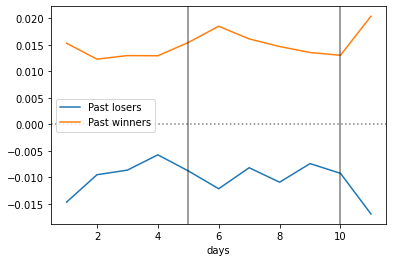

In [32]:
ax = bottom_portfolio_ret.groupby('days')['exret'].mean().plot(label='Past losers')
top_portfolio_ret.groupby('days')['exret'].mean().plot(ax=ax, label='Past winners')
ax.legend()
ax.axhline(y=0,  color='black', alpha=0.5, linestyle=':')
ax.axvline(x=5, color='black', alpha=0.5, linestyle='-')
ax.axvline(x=10, color='black', alpha=0.5, linestyle='-')

In [33]:
tset, pval = stats.ttest_ind(top_portfolio_ret[top_portfolio_ret['days']==5]['exret'],
                             bottom_portfolio_ret[top_portfolio_ret['days']==5]['exret'])

print('Mean Excess Return for Top Performing Funds ' + str(top_portfolio_ret[top_portfolio_ret['days']==5]['exret'].mean()))
print('Mean Excess Return for Bottom Performing Funds ' + str(bottom_portfolio_ret[top_portfolio_ret['days']==5]['exret'].mean()))
print('Mean Difference Bottom Minus Top in Excess Return ' + 
      str(bottom_portfolio_ret[top_portfolio_ret['days']==5]['exret'].mean() -                                                        
          top_portfolio_ret[top_portfolio_ret['days']==5]['exret'].mean()))

print('SD of the Excess Return for Top Performing Funds ' + str(top_portfolio_ret[top_portfolio_ret['days']==5]['exret'].std()))
print('SD of the Excess Return for Bottom Performing Funds ' + str(bottom_portfolio_ret[top_portfolio_ret['days']==5]['exret'].std()))
print('Correlation between Top and Bottom Performing Funds ' + 
      str(bottom_portfolio_ret[top_portfolio_ret['days']==5]['exret'].corr(top_portfolio_ret[top_portfolio_ret['days']==5]['exret'])))


print('P-values ' + str(pval))
if pval < 0.05:    # alpha value is 0.05 or 5%
    print(" we are rejecting null hypothesis")
else:
    print("we are accepting null hypothesis")

Mean Excess Return for Top Performing Funds 0.015436408250761193
Mean Excess Return for Bottom Performing Funds -0.008777697176959816
Mean Difference Bottom Minus Top in Excess Return -0.02421410542772101
SD of the Excess Return for Top Performing Funds 0.04001572748158246
SD of the Excess Return for Bottom Performing Funds 0.05900423126915534
Correlation between Top and Bottom Performing Funds -0.12611810314966498
P-values 0.004292657712476778
 we are rejecting null hypothesis


In [34]:
today=pd.to_datetime('20201102', format='%Y%m%d')
today

Timestamp('2020-11-02 00:00:00')

In [35]:
# Calculating the portfolio formed based on latest formation date
working_port = compute_performance_portfolios(today, combined_data)

In [36]:
working_port

(  symbol    lexret
 0    BEN -0.130450
 1   CTXS -0.138067
 2   DXCM -0.209778
 3   INTC -0.146247
 4   WLTW -0.137120,
   symbol    lexret
 0   ALGN  0.360278
 1    BKR  0.229742
 2    CMA  0.175450
 3    TPR  0.241671
 4     UA  0.174185)

In [37]:
working_port[:][0]

,symbol,lexret
0,BEN,-0.130450
1,CTXS,-0.138067
2,DXCM,-0.209778
3,INTC,-0.146247
4,WLTW,-0.137120


In [38]:
# Loser stocks for the latest portfolio formation period
print("Loser Stocks: " + working_port[0][:]['symbol'])
# working_port[0][:]['symbol']

0     Loser Stocks: BEN
1    Loser Stocks: CTXS
2    Loser Stocks: DXCM
3    Loser Stocks: INTC
4    Loser Stocks: WLTW
Name: symbol, dtype: object


In [39]:
# Winner stocks for the latest portfolio formation period
print("Winner Stocks: " + working_port[1][:]['symbol']) 
# working_port[1][:]['symbol']

0    Winner Stocks: ALGN
1     Winner Stocks: BKR
2     Winner Stocks: CMA
3     Winner Stocks: TPR
4      Winner Stocks: UA
Name: symbol, dtype: object
